### IMPORT LIBRARY AND CREATE FUNCTION FOR HRV ###

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from scipy import interpolate
from scipy.stats import zscore

def timedomain(rr):
    results = {}

    hr = 60000/rr

    # HRV metrics
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 20)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 20)*1) / len(rr)
    return results

def frequency_domain(rri, fs, nperseg=256):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rri, fs=fs)

    '''
    Segement found frequencies in the bands
     - Very Low Frequency (VLF): 0-0.04Hz
     - Low Frequency (LF): 0.04-0.15Hz
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)

    # calculate power in each band by integrating the spectral density
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])

    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)

    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results

def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)

    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")

    return sd1, sd2

            time       ecg
0        729.500  0.546875
1        729.501  0.553125
2        729.502  0.540625
3        729.503  0.537500
4        729.504  0.553125
...          ...       ...
309995  1039.495  0.006250
309996  1039.496  0.009375
309997  1039.497  0.018750
309998  1039.498  0.003125
309999  1039.499 -0.028125

[310000 rows x 2 columns]


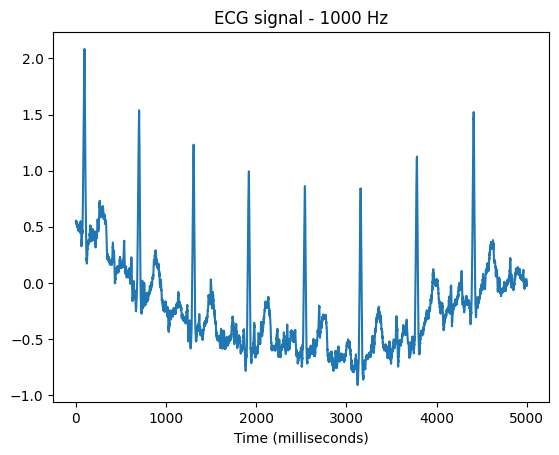

In [96]:
# Import data
path = r'/content/sample_file_ECG.csv'
df = pd.read_csv(path)
print(df)

# plot
plt.title("ECG signal - 1000 Hz")
plt.plot(df.ecg[0:5000])
plt.xlabel('Time (milliseconds)')
plt.show()

### R-R PEAK DETECTION ###

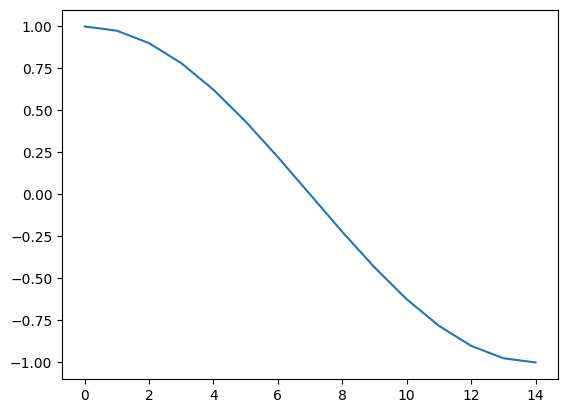

In [97]:
# linear spaced vector between 0.5 pi and 1.5 pi
v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)

# create sine filter for approximating QRS feature
peak_filter = np.sin(v)
plt.plot(peak_filter)



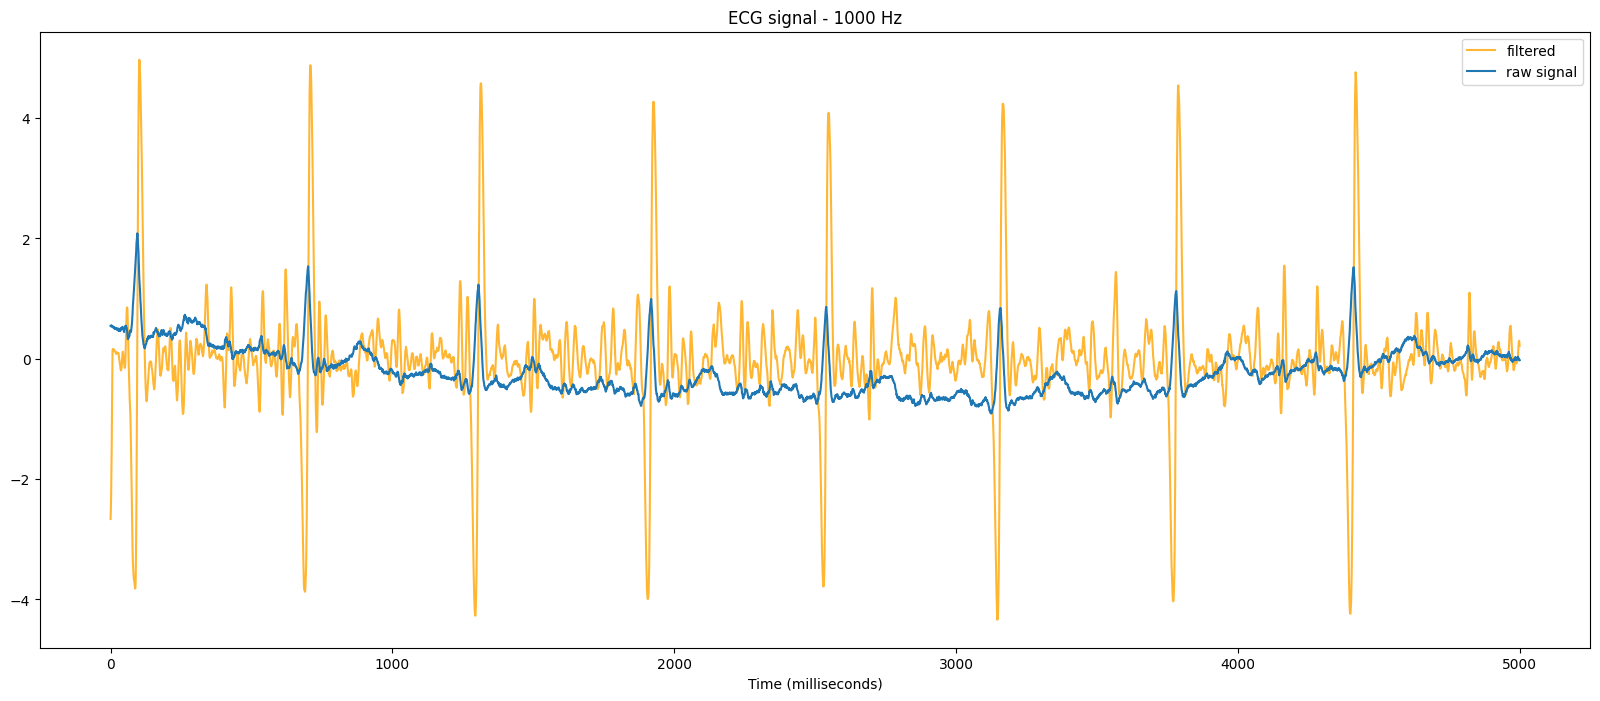

In [98]:

plt.figure(figsize=(20,8))
plt.title('ECG signal - 1000 Hz')
plt.plot(ecg_transformed[0:5000], alpha = 0.8, c='orange')
plt.plot(df.ecg[0:5000], alpha = 1)
plt.gca().legend(('filtered','raw signal'))
plt.xlabel('Time (milliseconds)')
plt.show()

### PEAK DETECTION ###

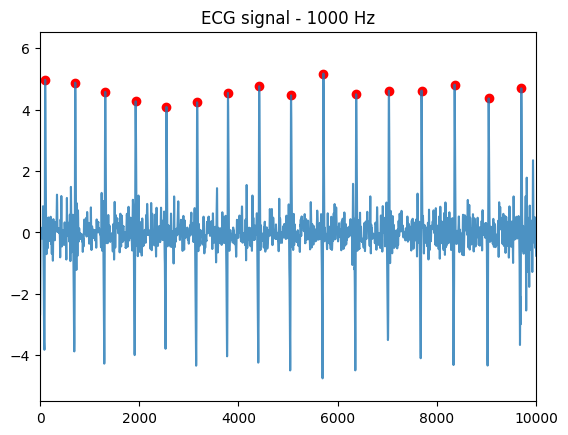

In [99]:
# calculates the differences between consecutive samples
diff_sig_ecg = np.diff(df['ecg'])

rr_peaks, _ = find_peaks(ecg_transformed, distance=1000*(30/60))
plt.plot(ecg_transformed, alpha = 0.8)
plt.scatter(rr_peaks, ecg_transformed[rr_peaks], color='red')
plt.xlim(0,10000)
plt.title("ECG signal - 1000 Hz")
plt.show()

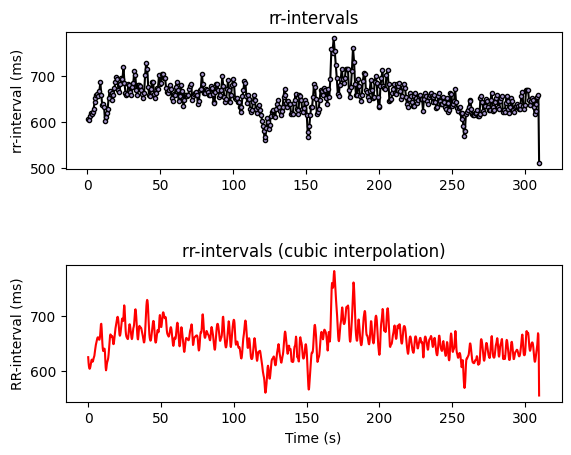

In [100]:
# compute the diff along the time axis to end up with the R-R intervals
rr_ecg = np.diff(rr_peaks)

# fit function to the dataset
x_ecg = np.cumsum(rr_ecg)/1000
f_ecg = interp1d(x_ecg, rr_ecg, kind='cubic', fill_value= 'extrapolate')

# sample rate for interpolation
fs = 4
steps = 1 / fs

# sample using the interpolation function
xx_ecg = np.arange(0, np.max(x_ecg), steps)
rr_interpolated_ecg = f_ecg(xx_ecg)

plt.subplot(211)
plt.title('rr-intervals')
plt.plot(x_ecg, rr_ecg, color='k', markerfacecolor='#A999D1',marker='o', markersize=3)
plt.ylabel('rr-interval (ms)')

plt.subplots_adjust(hspace=0.7)

plt.subplot(212)
plt.title('rr-intervals (cubic interpolation)')
plt.plot(xx_ecg, rr_interpolated_ecg, color='r')
plt.xlabel('Time (s)')
plt.ylabel('RR-interval (ms)')

plt.show()

### CLEANING AND DEALING WITH OUTLIERS ####

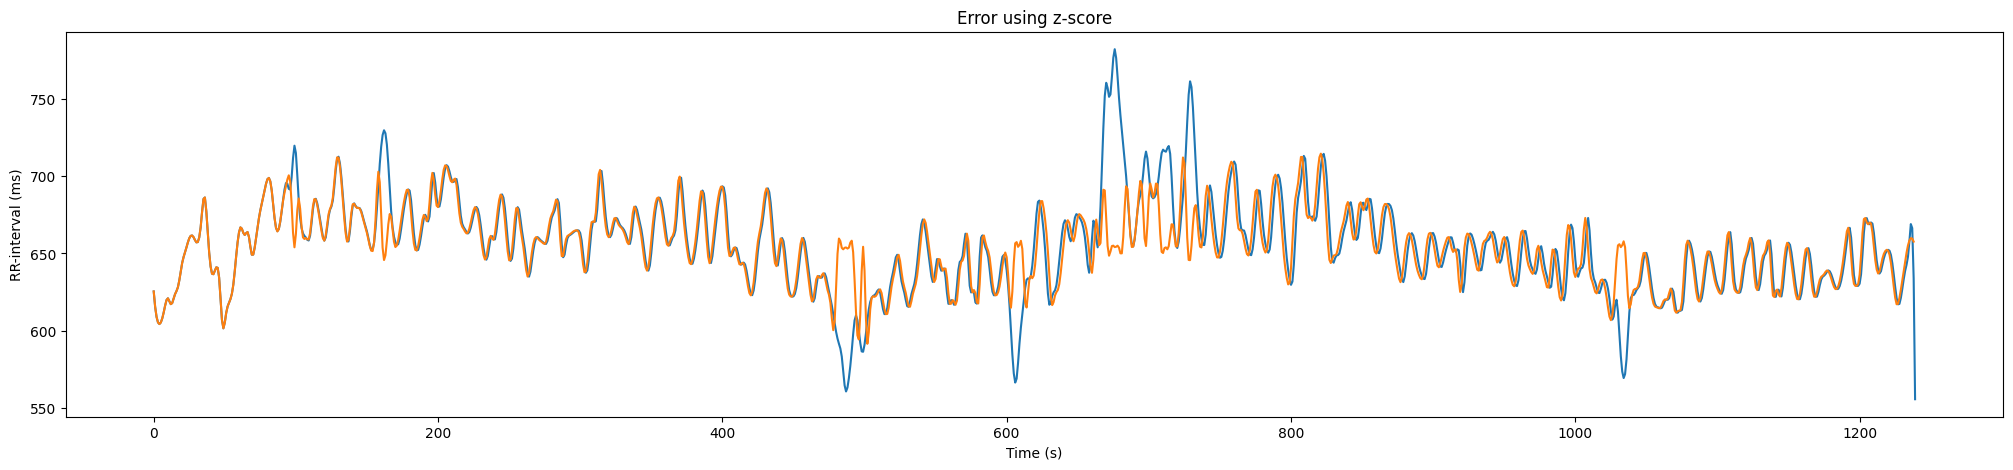

In [101]:
rr_ecg[np.abs(zscore(rr_ecg)) > 2] = np.median(rr_ecg)

x_ecg = np.cumsum(rr_ecg)/1000
f_ecg = interp1d(x_ecg, rr_ecg, kind='cubic', fill_value= 'extrapolate')

xx_ecg = np.arange(0, np.max(x_ecg), steps)
clean_rr_interpolated_ecg = f_ecg(xx_ecg)

plt.figure(figsize=(25,5))
plt.title('Error using z-score')
plt.plot(rr_interpolated_ecg)
plt.plot(clean_rr_interpolated_ecg)
plt.xlabel('Time (s)')
plt.ylabel('RR-interval (ms)')
plt.show()

In [102]:
timedomain(rr_ecg)

{'Mean RR (ms)': 653.4620253164557,
 'STD RR/SDNN (ms)': 22.928149395811662,
 "Mean HR (Kubios' style) (beats/min)": 91.81864848373318,
 'Mean HR (beats/min)': 91.93147870065602,
 'STD HR (beats/min)': 3.218932498633968,
 'Min HR (beats/min)': 84.15147265077138,
 'Max HR (beats/min)': 100.84033613445378,
 'RMSSD (ms)': 17.17260958866085,
 'NNxx': 102,
 'pNNxx (%)': 21.518987341772153}

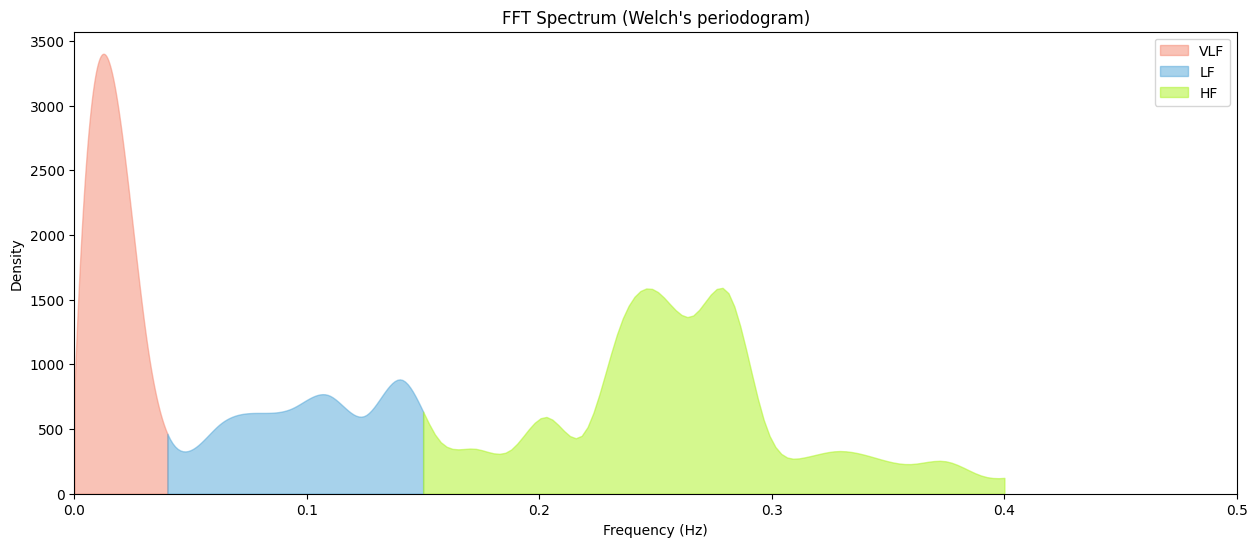

In [103]:
fxx, pxx = signal.welch(x=clean_rr_interpolated_ecg, fs=fs, nperseg=256)

#fit a function for plotting bands
powerspectrum_f = interp1d(fxx, pxx, kind='cubic', fill_value= 'extrapolate')

plt.figure(figsize=(15,6))
# plt.plot(fxx,pxx,color='k',linewidth=0.5)
plt.title("FFT Spectrum (Welch's periodogram)")

# setup frequency bands for plotting
x_VLF = np.linspace(0, 0.04, 100)
x_LF = np.linspace(0.04, 0.15, 100)
x_HF = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_VLF, powerspectrum_f(x_VLF), alpha=0.5, color="#F5866F", label="VLF")
plt.gca().fill_between(x_LF, powerspectrum_f(x_LF), alpha=0.5, color="#51A6D8", label="LF")
plt.gca().fill_between(x_HF, powerspectrum_f(x_HF), alpha=0.5, color="#ABF31F", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")

plt.legend()
plt.show()

In [104]:
frequency_domain(clean_rr_interpolated_ecg, fs=fs)

{'Power VLF (ms2)': 66.69158059646628,
 'Power LF (ms2)': 59.23657234926308,
 'Power HF (ms2)': 151.72024786921173,
 'Power Total (ms2)': 277.64840081494106,
 'LF/HF': 0.39043287353661005,
 'Peak VLF (Hz)': 0.015625,
 'Peak LF (Hz)': 0.140625,
 'Peak HF (Hz)': 0.25,
 'Fraction LF (nu)': 28.07995128477736,
 'Fraction HF (nu)': 71.92004871522265}

(12.142665410283454, 30.02672855437516)

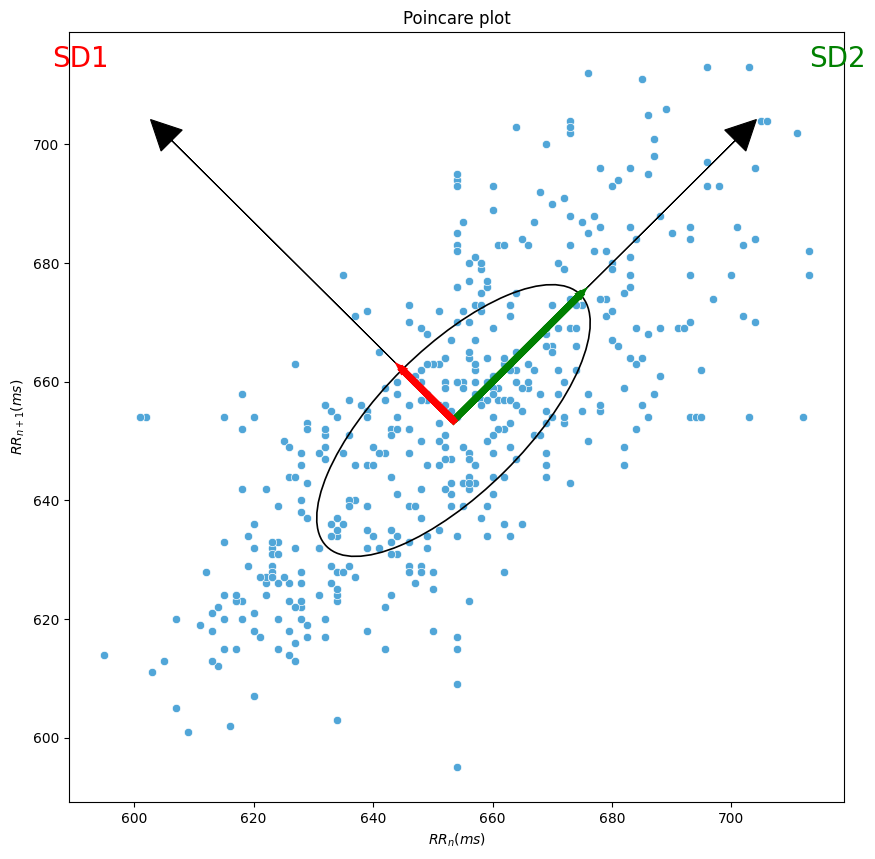

In [105]:
plot_poincare(rr_ecg)